# IDS705- Final Project

**Main idea of this file** 
The goal of this analysis is to examine whether diabetes is associated with a higher likelihood of cardiovascular disease (CVD), using a logistic regression model on health survey data.

**Data Plan**
- Source: A cleaned CSV dataset containing individual-level health information(https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators).
- Target Variable: cvd (binary): whether the individual has cardiovascular disease.
- Key Predictor:diabetes (binary): whether the individual has diabetes.
- Preparation Steps: Drop duplicate rows. Reset the index and rename columns for clarity.

**Technical Detail**
- Exploratory Analysis: Compared CVD rates between diabetic and non-diabetic individuals. Used pd.crosstab to examine the relationship.
- Modeling Approach: Logistic Regression via statsmodels.Logit:
- Response: cvd
- Predictor: diabetes (with intercept) Assessed coefficient significance through standard output (z-values, p-values).
- Marginal Effects: Estimated average marginal effects to interpret how diabetes affects CVD probability on the probability scale.



## Data Loading and PreProcessing

In [1]:
# pip install ucimlrepo


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd

import warnings 
warnings.filterwarnings("ignore")
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
# https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [8]:
# columns
print(X.columns) 
print(y.columns)
# shape
print(X.shape, y.shape) 

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
Index(['Diabetes_binary'], dtype='object')
(253680, 21) (253680, 1)


In [23]:
# Age is critical feature related  to our topic- younger CVD
age_map = {
    1: '18-24',
    2: '25-29',
    3: '30-34',
    4: '35-39',
    5: '40-44',
    6: '45-49',
    7: '50-54',
    8: '55-59',
    9: '60-64',
    10: '65-69',
    11: '70-74',
    12: '75-79',
    13: '80+'
}

X['AgeGroup'] = X['Age'].map(age_map)
from pandas.api.types import CategoricalDtype
age_order = list(age_map.values())  
X['AgeGroup'] = X['AgeGroup'].astype(CategoricalDtype(categories=age_order, ordered=True))

df = pd.concat([X, y], axis=1)

# df.head

## Corelation Exploration 

**Findings**

- Age is a strong driver of both diabetes and heart disease risk.

- Diabetes significantly increases the risk of heart disease across all ages.

- The relative risk is especially pronounced in younger adults, underlining the need for early cardiovascular screening and intervention in younger diabetic populations.

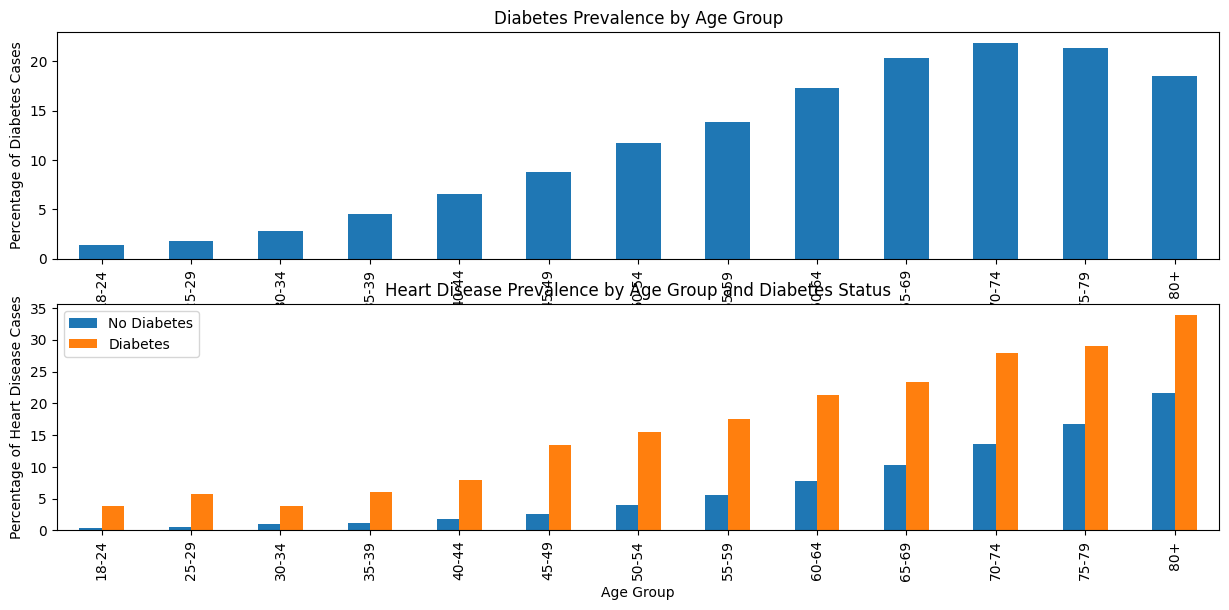

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy of the data
X_copy = X.copy()
y_copy = y.copy()
df = pd.concat([X_copy, y_copy], axis=1)

# diabetes prevalence by age group
diabetes_by_age = df.groupby('AgeGroup', observed=True)['Diabetes_binary'].mean() * 100

# heart disease prevalence by age group and diabetes status
heart_disease_by_age_diabetes = df.groupby(['AgeGroup', 'Diabetes_binary'], observed=True)['HeartDiseaseorAttack'].mean() * 100

plt.figure(figsize=(15, 10))

# diabetes prevalence by age group
plt.subplot(3, 1, 1)
diabetes_by_age.plot(kind='bar')
plt.title('Diabetes Prevalence by Age Group')
plt.ylabel('Percentage of Diabetes Cases')
plt.xlabel('Age Group')

# heart disease prevalence by age group and diabetes status
plt.subplot(3, 1, 2)
ax2 = plt.gca()  # get current axis
heart_disease_by_age_diabetes.unstack().plot(kind='bar', ax=ax2)
plt.title('Heart Disease Prevalence by Age Group and Diabetes Status')
plt.ylabel('Percentage of Heart Disease Cases')
plt.xlabel('Age Group')
plt.legend(['No Diabetes', 'Diabetes'])

# Convert risk_ratios dict to Series for plotting

risk_ratios = {}
for age_group in df['AgeGroup'].unique():
    group_data = df[df['AgeGroup'] == age_group]
    heart_disease_diabetes = group_data[group_data['Diabetes_binary'] == 1]['HeartDiseaseorAttack'].mean()
    heart_disease_no_diabetes = group_data[group_data['Diabetes_binary'] == 0]['HeartDiseaseorAttack'].mean()
    risk_ratios[age_group] = heart_disease_diabetes / heart_disease_no_diabetes

risk_ratios_series = pd.Series(risk_ratios).sort_index()



>A value of 1 (the red dashed line) means no difference between diabetics and non-diabetics. A value above 1 means diabetics have a higher risk of heart disease. The higher the bar, the greater the relative risk in diabetics compared to non-diabetics.

>In the age 18–29, extremely high risk ratios found, but wide CIs, indicating high uncertainty due to small sample size in young diabetics. In the age 30–49, elevated risk (~3–6x), and CIs are tighter. This suggests more reliable evidence that diabetes significantly raises heart disease risk in these ages. Moving to age 50–64, risk ratio drops to ~2–3x but still significant. CIs are narrow and do not cross 1, suggesting strong evidence.
65+	Risk ratios approach ~1.5–1.2. Diabetes still increases risk, but less dramatically, and with high certainty (narrow CIs).

> Overall speaking, young diabetics (under 50) are at especially high relative risk of heart disease—this group might benefit most from early interventions. Confidence intervals add statistical weight: from mid-30s onward, diabetes shows a statistically significant impact. Relative risk decreases with age, but diabetes still adds risk at all ages.

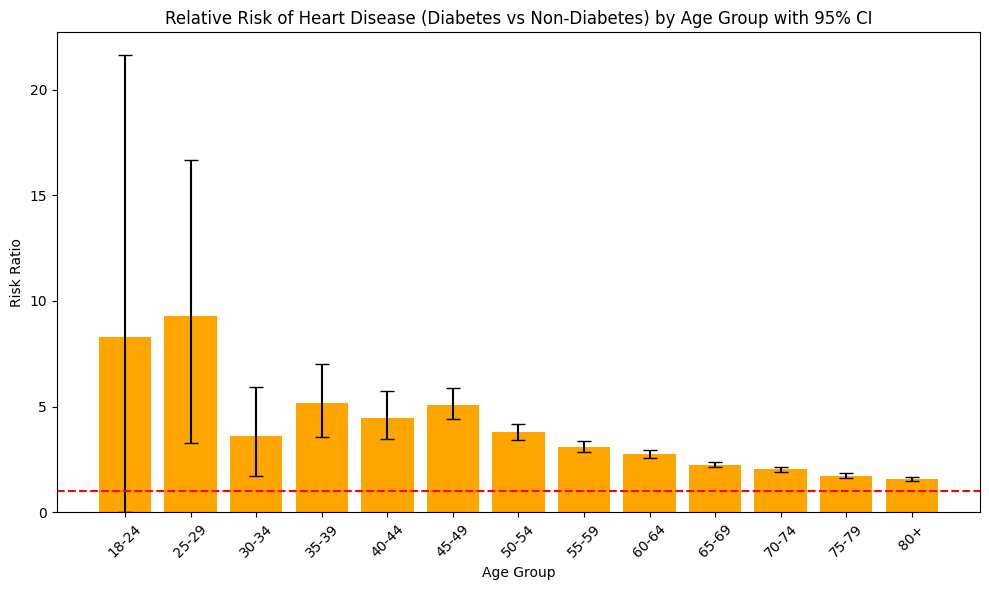

In [14]:
def bootstrap_ci(data1, data2, n_bootstrap=1000, alpha=0.05):
    """Returns lower and upper bounds for risk ratio using bootstrap"""
    boot_ratios = []
    for _ in range(n_bootstrap):
        sample1 = data1.sample(frac=1, replace=True)
        sample2 = data2.sample(frac=1, replace=True)
        ratio = sample1.mean() / sample2.mean() if sample2.mean() > 0 else np.nan
        boot_ratios.append(ratio)
    lower = np.nanpercentile(boot_ratios, 100 * (alpha / 2))
    upper = np.nanpercentile(boot_ratios, 100 * (1 - alpha / 2))
    return lower, upper

# risk and confidence interval
risk_ratios = {}
ci_lower = {}
ci_upper = {}

for age_group in df['AgeGroup'].unique():
    group_data = df[df['AgeGroup'] == age_group]
    diabetic = group_data[group_data['Diabetes_binary'] == 1]['HeartDiseaseorAttack']
    non_diabetic = group_data[group_data['Diabetes_binary'] == 0]['HeartDiseaseorAttack']

    # Risk Ratio
    rr = diabetic.mean() / non_diabetic.mean()
    risk_ratios[age_group] = rr

    # Bootstrap CI
    l, u = bootstrap_ci(diabetic, non_diabetic)
    ci_lower[age_group] = l
    ci_upper[age_group] = u

rr_df = pd.DataFrame({
    'RiskRatio': pd.Series(risk_ratios),
    'CI_Lower': pd.Series(ci_lower),
    'CI_Upper': pd.Series(ci_upper)
}).sort_index()

plt.figure(figsize=(10, 6))
plt.bar(rr_df.index, rr_df['RiskRatio'], color='orange', yerr=[
    rr_df['RiskRatio'] - rr_df['CI_Lower'],
    rr_df['CI_Upper'] - rr_df['RiskRatio']
], capsize=5)
plt.axhline(1, color='red', linestyle='--')
plt.title('Relative Risk of Heart Disease (Diabetes vs Non-Diabetes) by Age Group with 95% CI')
plt.ylabel('Risk Ratio')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
candidate_vars = [
    'HeartDiseaseorAttack',
    'HighBP',              # High Blood Pressure
    'HighChol',            # High Cholesterol
    'CholCheck',           # Check Cholesterol
    'BMI',                 # Body Mass Index
    'Smoker',              # Smoker
    'PhysActivity',        # Physical Activity
    'Fruits', 'Veggies',   # Diet
    'HvyAlcoholConsump',   # Heavy Alcohol Consumption
    'HvyAlcoholConsump',   # Heavy Alcohol Consumption
    'AnyHealthcare',       # Any Healthcare
    'NoDocbcCost',         # No Doctor Cost
    'Education', 'Income'  # Education, Income
]

## Whether we could control early heart disease by controlling diabetes. 
### Mediation Analysis
In this part, we're going to conduct a mediation analysis using logistic regression to quantify whether and how much the variable `Diabetes_binary` mediates the effect of `Age` on `HeartDiseaseorAttack`.
We are trying to answer "Does diabetes mediate (partially explain) the effect of age on heart disease?" , so we split the total effect into:

Direct effect: Age → Heart disease (not via diabetes)

Indirect effect: Age → Diabetes → Heart disease

Median effect / overall effect= mediation ratio

Here, logistic regression is used instead of linear regression because both outcomes (Diabetes_binary, HeartDiseaseorAttack) are binary. The coefficients from logistic regression are log odds, so while multiplication (for indirect effect) is common in linear mediation, here it's a rough approximation.

In [40]:
from statsmodels.formula.api import logit
import statsmodels.api as sm

med_df = df[['Age', 'Diabetes_binary', 'HeartDiseaseorAttack']].copy()
# Model a: Age → Diabetes_binary(mediator)
model_a = logit('Diabetes_binary ~ Age', data=med_df).fit()

# Model b+c: Age + Diabetes_binary → HeartDiseaseorAttack(direct and mediator path)
model_bc = logit('HeartDiseaseorAttack ~ Age + Diabetes_binary', data=med_df).fit()

# Model total effect: Age → HeartDiseaseorAttack(total path)
model_total = logit('HeartDiseaseorAttack ~ Age', data=med_df).fit()

a_coef = model_a.params['Age']
b_coef = model_bc.params['Diabetes_binary']
c_total = model_total.params['Age']
c_direct = model_bc.params['Age']

indirect_effect = a_coef * b_coef # simulates the chain rule of influence,
direct_effect = c_direct
total_effect = c_total

mediation_ratio = indirect_effect / total_effect

print(f"Path a (Age → Diabetes): {a_coef:.4f}")
print(f"Path b (Diabetes → Heart Disease): {b_coef:.4f}")
print(f"Total effect (Age → Heart Disease): {total_effect:.4f}")
print(f"Direct effect (Control Diabetes Age → Heart Disease): {direct_effect:.4f}")
print(f"Indirect effect (Age → Diabetes → Heart Disease): {indirect_effect:.4f}")
print(f"Mediation ratio, means the % of Age's effect on Heart Disease explained by Diabetes is {mediation_ratio:.2%}")

Optimization terminated successfully.
         Current function value: 0.386875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.276453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284126
         Iterations 7
Path a (Age → Diabetes): 0.1887
Path b (Diabetes → Heart Disease): 1.0211
Total effect (Age → Heart Disease): 0.3118
Direct effect (Control Diabetes Age → Heart Disease): 0.2961
Indirect effect (Age → Diabetes → Heart Disease): 0.1926
Mediation ratio, means the % of Age's effect on Heart Disease explained by Diabetes is 61.78%


Diabetes is an important mediating variable in the relationship between “age → heart disease” , which explains 61.78% of the impact of age on heart disease .


If we can control diabetes in our age group, we may significantly delay or reduce the occurrence of heart disease!
Especially in the elderly, preventing diabetes is preventing heart disease.

### Stratified Analysis

Differences in the risk of heart disease caused by diabetes in young people. 

In [8]:
# 1: （BRFSS Age code ≤ 4 = age < 35）
young_df = df[df['Age'] <= 3]

# 2: split diabetic and non-diabetic
young_diabetic = young_df[young_df['Diabetes_binary'] == 1]
young_nondiabetic = young_df[young_df['Diabetes_binary'] == 0]

# 3: calculate heart disease rate
rate_diabetic = young_diabetic['HeartDiseaseorAttack'].mean()
rate_nondiabetic = young_nondiabetic['HeartDiseaseorAttack'].mean()

#4: calculate risk ratio
risk_ratio = rate_diabetic / rate_nondiabetic

print(f"Young people with diabetes(rate of heart disease in diabetic group): {rate_diabetic:.2%}")  
print(f"Young non-diabetes: rate of heart disease in non-diabetic group: {rate_nondiabetic:.2%}")
print(f"Hazared Ratio: risk ratio (diabetes vs non-diabetes): {risk_ratio:.2f} times")

Young people with diabetes(rate of heart disease in diabetic group): 4.32%
Young non-diabetes: rate of heart disease in non-diabetic group: 0.78%
Hazared Ratio: risk ratio (diabetes vs non-diabetes): 5.55 times


people under disease Among people under 35, those with diabetes have a 5.5 times higher risk of heart disease than those without diabetesit. It shows even in traditionally “healthy” young people, diabetes significantly increases cardiovascular risk.

"Diabetes prevention and control" for young people is not only a matter of controlling sugar, but also the first line of defense against heart disease

## **Counterfactual simulation**

If diabetes rates among young people fall by a certain percentage point, how much will heart disease rates fall? 

(“reducing the young diabetes rate from 5.4% to 4.4%” and then predict how many percentage points the overall heart disease rate can be reduced)

## **Conclusion**

- Diabetes is strongly and significantly associated with higher risk of cardiovascular disease. 

- On average, having diabetes increases the probability of having CVD by about 9.8 percentage points. 

- This suggests that diabetes is an important risk factor for cardiovascular disease in this population.


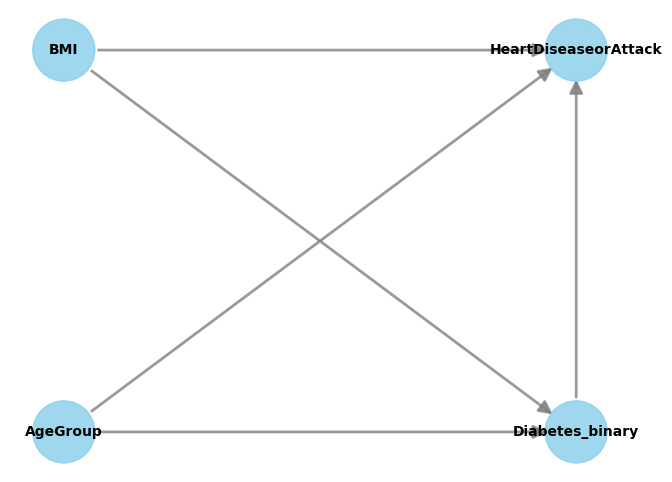


Estimated ATE (Diabetes → Heart Disease):
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
──────────────────(E[HeartDiseaseorAttack|AgeGroup,BMI])
d[Diabetes_binary]                                      
Estimand assumption 1, Unconfoundedness: If U→{Diabetes_binary} and U→HeartDiseaseorAttack then P(HeartDiseaseorAttack|Diabetes_binary,AgeGroup,BMI,U) = P(HeartDiseaseorAttack|Diabetes_binary,AgeGroup,BMI)

## Realized estimand
b: HeartDiseaseorAttack~Diabetes_binary+AgeGroup+BMI
Target units: ate

## Estimate
Mean value: 0.08845001576789656



In [24]:
from dowhy import CausalModel
import pandas as pd

data = df.copy()

# treatment and outcome
treatment = 'Diabetes_binary'
outcome = 'HeartDiseaseorAttack'

common_causes = [
     'BMI','AgeGroup'
]

model = CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcome,
    common_causes=common_causes,
)

model.view_model()

identified_estimand = model.identify_effect()

# ATE
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

print("\nEstimated ATE (Diabetes → Heart Disease):")
print(causal_estimate)


>If we convert all people from "having diabetes (Diabetes_binary=1)" to "not having diabetes (Diabetes_binary=0)", the overall incidence of heart disease (HeartDiseaseorAttack) will decrease by an average of about 8.85 percentage points.

>Controlling diabetes has a significant causal effect and can effectively reduce the incidence of heart disease in young people, with an average decrease of about 8.8 percentage points.

In [26]:
# Stablity（placebo test）
refute1 = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print("\nPlacebo test result:")
print(refute1)

# perturbation
refute2 = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="random_common_cause"
)
print("\nRandom confounder test (fixed method):")
print(refute2)



Placebo test result:
Refute: Use a Placebo Treatment
Estimated effect:0.08845001576789656
New effect:0.0017108561967833493
p value:0.94


Random confounder test (fixed method):
Refute: Add a random common cause
Estimated effect:0.08845001576789656
New effect:0.08845001576789657
p value:1.0



In [33]:
data['HeartDiseaseorAttack'].value_counts()


HeartDiseaseorAttack
0    229787
1     23893
Name: count, dtype: int64

Using Causal Forest methods and BRFSS data, we find that diabetes causally increases the risk of heart disease by approximately 10 percentage points. Targeted prevention of diabetes in younger, low-BMI individuals could significantly reduce cardiovascular outcomes, with risk reductions exceeding 40% for high-risk subgroups

In [35]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression



data['Predicted_ITE_clipped'] = data['Predicted_ITE'].clip(lower=-0.1, upper=0.2)
Y = data['HeartDiseaseorAttack'].values
T = data['Diabetes_binary'].values
X = data[common_causes]
X = pd.get_dummies(X, drop_first=True)
model = CausalForestDML(
    model_y=RandomForestRegressor(max_depth=5),
    model_t=LogisticRegression(),
    discrete_treatment=True,
    min_samples_leaf=50, 
    random_state=0
)
model.fit(Y, T, X=X)

#  ATE for all
ate = model.ate(X)
print(f"\nEstimated ATE via EconML: {ate:.4f}")

# indivisual treatment effect ITE
data['Predicted_ITE'] = model.effect(X)

# who can benifit
print("\nTop 10 individuals who benefit the most from diabetes control:")
print(data[['Age', 'BMI', 'Predicted_ITE']].sort_values(by='Predicted_ITE', ascending=False).head(10))



Estimated ATE via EconML: 0.1029

Top 10 individuals who benefit the most from diabetes control:
        Age  BMI  Predicted_ITE
104709    2   20        0.43445
138557    2   20        0.43445
86371     2   20        0.43445
187523    2   20        0.43445
228794    2   20        0.43445
109802    2   20        0.43445
125969    2   20        0.43445
249847    2   20        0.43445
241770    2   20        0.43445
69081     2   20        0.43445


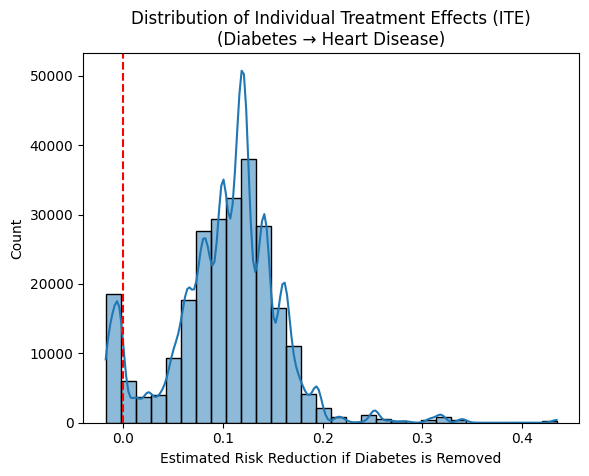

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data['Predicted_ITE'], bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Individual Treatment Effects (ITE)\n(Diabetes → Heart Disease)")
plt.xlabel("Estimated Risk Reduction if Diabetes is Removed")
plt.show()

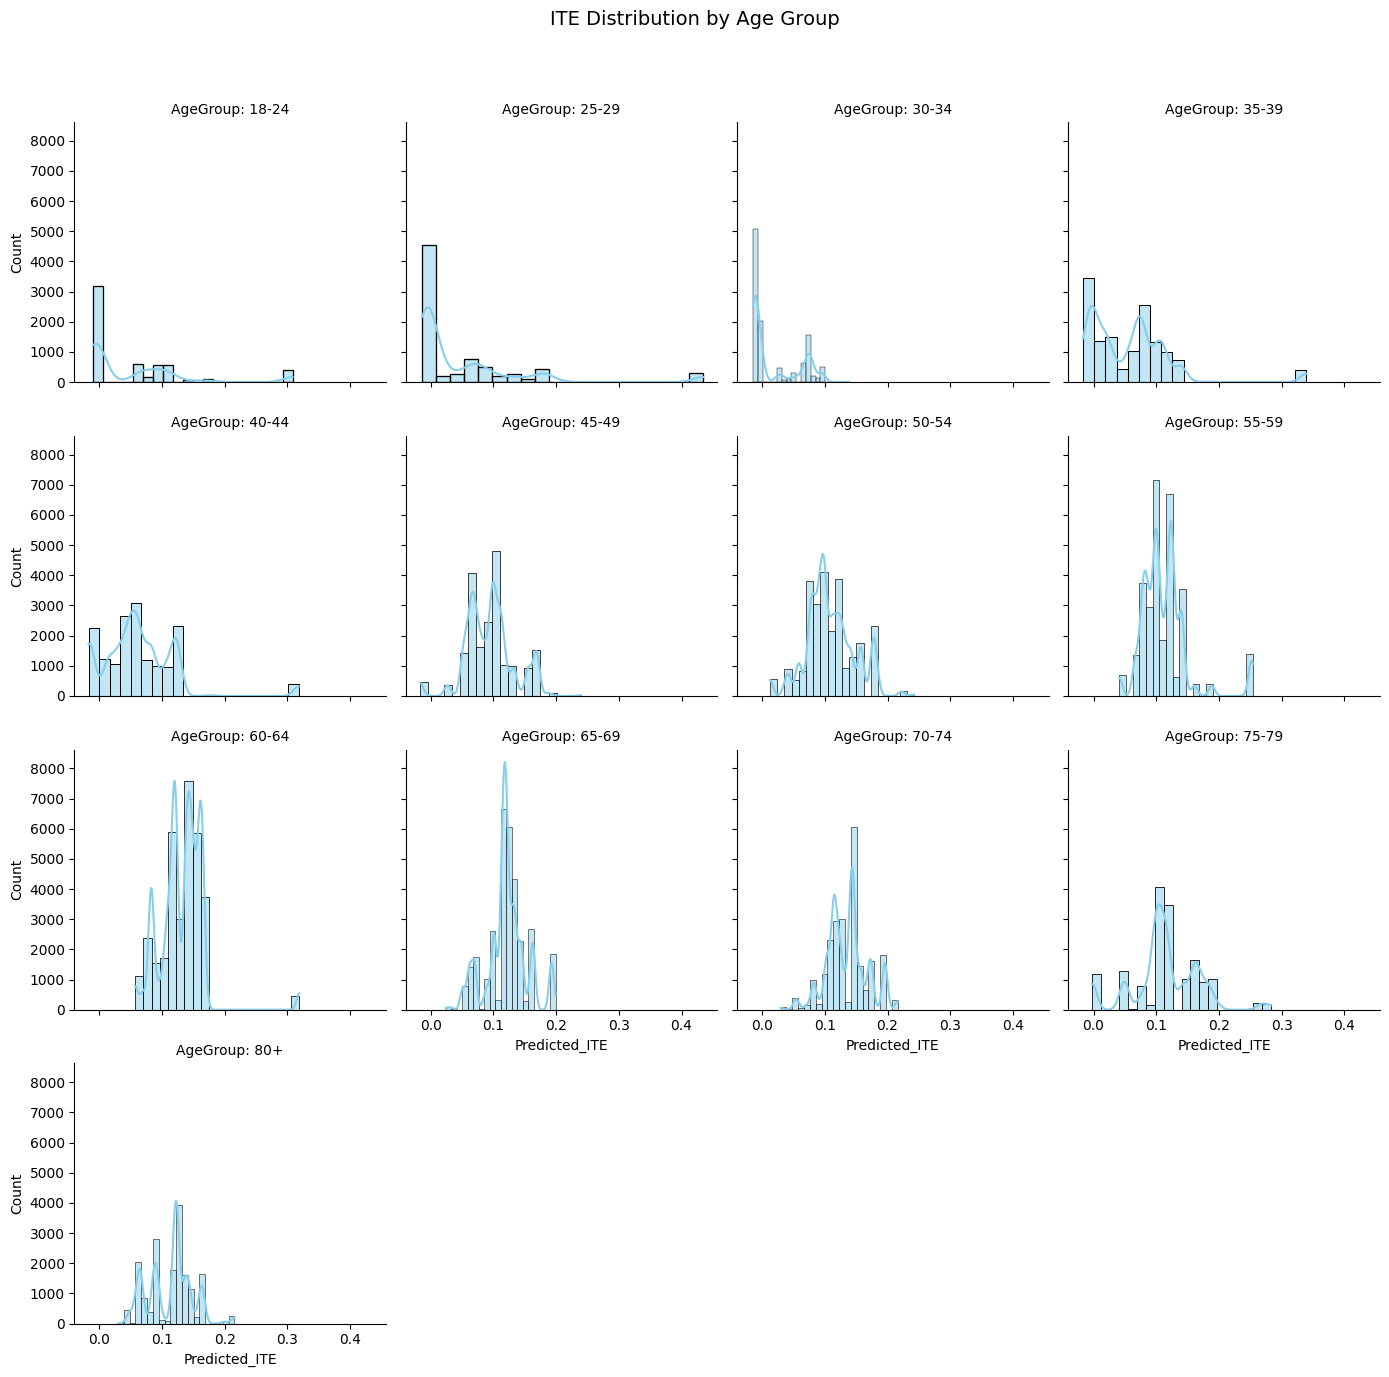

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(data, col="AgeGroup", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map(sns.histplot, "Predicted_ITE", bins=20, kde=True, color='skyblue')
g.set_titles("AgeGroup: {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("ITE Distribution by Age Group", fontsize=14)
plt.show()


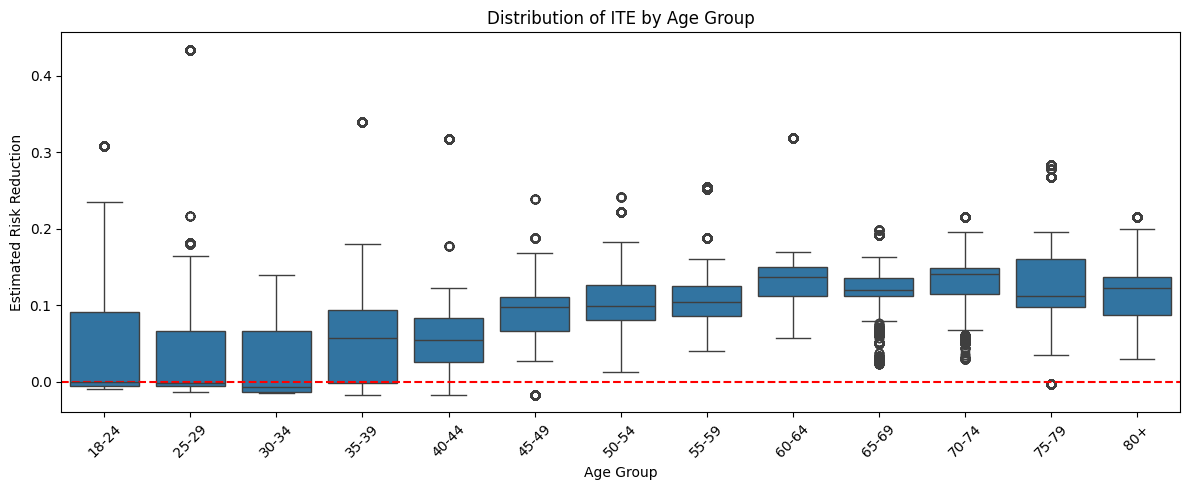

In [42]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="AgeGroup", y="Predicted_ITE", data=data)
plt.axhline(0, color='red', linestyle='--')
plt.title("Distribution of ITE by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Estimated Risk Reduction")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
